In [1]:
from importlib import reload
from src import data_setup, engine, models, utils
[reload(module) for module in [data_setup, engine, models, utils]]; # During Development

In [2]:
# Verify installation and initialize computing device
device = engine.initialize()

[CONNECTED] NVIDIA GeForce RTX 3070


In [3]:
# Verify/Download image dataset(s) from a zip file(s)
url = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip'
data_path = data_setup.download_data('data', url=url, dataset_name='PSS_0.2')

[INFO] Did not find 'data\PSS_0.2' directory. Creating one:
[INFO] Downloading 'PSS_0.2' dataset from 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip':
Total size = 30.03 MiB


100%|██████████| 31/31 [00:02<00:00, 10.33MiB/s]


[INFO] Extracting 'data\PSS_0.2\data_file.zip' .. done.


In [4]:
from torchvision.models import \
    EfficientNet_B1_Weights as EB1w, \
    efficientnet_b1 as EB1

from torchvision.transforms import TrivialAugmentWide, Compose
from os import cpu_count

# Same transformation used for imported pretrained weights
auto_transform = EB1w.DEFAULT.transforms()

# DataLoaders configurations
directories = [data_path/subset for subset in ('train', 'test')]
transforms = [Compose([TrivialAugmentWide(), auto_transform]), auto_transform]
splits = [(0.8, 0.2), None]
shuffles = [True, False]
batch_size = 32

train_loader, val_loader, test_loader, classes = data_setup.create_dataloaders(
    directories=directories, transforms=transforms, splits=splits, shuffles=shuffles,
    batch_size=batch_size, num_workers=cpu_count()//6, device=device
)

Loader#0: 384 samples
Loader#1: 96 samples
Loader#2: 160 samples
Target: ['pizza', 'steak', 'sushi']


In [5]:
# Getting the data transformation size (optional)
size = [auto_transform.resize_size[0]]*2

# Modifying the pretrained model's head and freezing the rest
pre_trained_model = EB1(weights=EB1w.DEFAULT)
model = models.fine_tune_on_classes(pre_trained_model, target=classes, device=device, input_size=size)
model.summary()

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [1, 3, 255, 255]     [1, 3]               --                   Partial
├─Sequential: 1-1                                       [1, 3, 255, 255]     [1, 1280, 8, 8]      --                   False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 255, 255]     [1, 32, 128, 128]    --                   False
│    │    └─Conv2d: 3-1                                 [1, 3, 255, 255]     [1, 32, 128, 128]    (864)                False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 128, 128]    [1, 32, 128, 128]    (64)                 False
│    │    └─SiLU: 3-3                                   [1, 32, 128, 128]    [1, 32, 128, 128]    --                   --
│    └─Sequential: 2-2                                  [1, 32, 128, 128]    [1, 16, 128, 128]    --                   Fal

In [6]:
# Clear potential zombie processes
engine.clear_processes()

# Training engine for a classification problem
trainer = engine.ClassTrainer(model)

trainer.run(train_loader, val_loader, epochs=50, model_name='EffNetB1_50e')

[INFO] Initializing Tensorboard for:
	runs\2023-06-16_Evaar\16-19-43\EffNetB1_50e
[INFO] Initializing Training Process - First Evaluation
[INFO] Training Started.
--------------------
[01] ###### [100.0%] | train: l=1.03, a=060.56% [0.11/1.65s] | val: l=0.90, a=077.78% | lr=0.001000
[02] ###### [100.0%] | train: l=0.88, a=078.06% [0.02/1.54s] | val: l=0.77, a=084.44% | lr=0.000975
[03] ###### [100.0%] | train: l=0.78, a=079.72% [0.02/1.56s] | val: l=0.67, a=088.89% | lr=0.000951
[04] ###### [100.0%] | train: l=0.69, a=083.89% [0.02/1.51s] | val: l=0.61, a=088.89% | lr=0.000927
[05] ###### [100.0%] | train: l=0.60, a=087.50% [0.02/1.55s] | val: l=0.55, a=092.22% | lr=0.000904
[06] ###### [100.0%] | train: l=0.56, a=090.00% [0.02/1.51s] | val: l=0.49, a=096.67% | lr=0.000881
[07] ###### [100.0%] | train: l=0.50, a=091.11% [0.02/1.55s] | val: l=0.48, a=092.22% | lr=0.000859
[08] ###### [100.0%] | train: l=0.50, a=091.11% [0.02/1.52s] | val: l=0.43, a=093.33% | lr=0.000838
[09] ###### [100

'2023-06-16_Evaar'

In [7]:
trainer.evaluate(test_loader, classes)
trainer.writer.close()

[100.0%]

Shutting down workers at [10096, 14104]
Mean Average Values:
--------------------
Loss		0.2111
Acc			0.9733
Precision	0.9727
Recall		0.9725
F1 Score	0.9725
AUC			0.9949


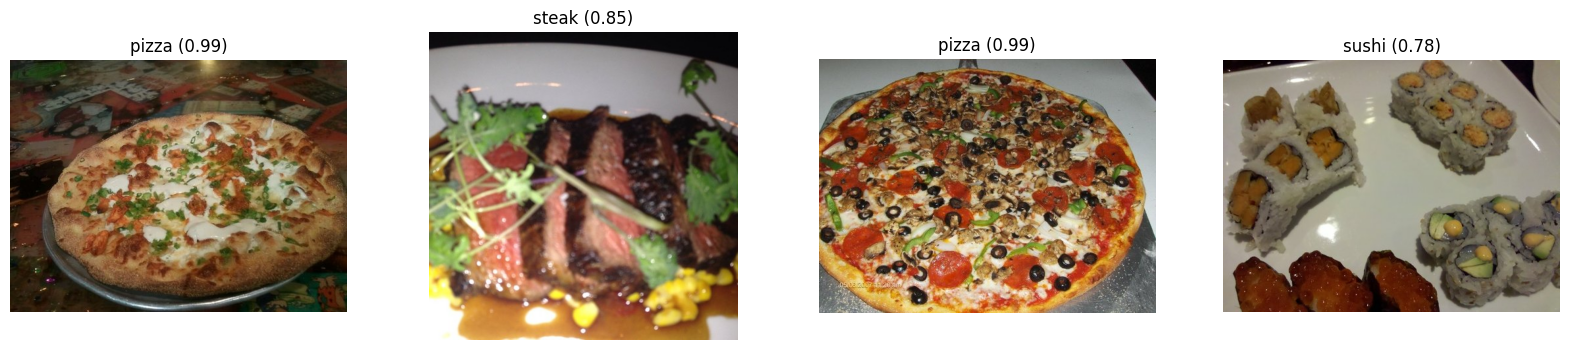

In [8]:
engine.inference(model, data_path/'test', classes, transform=auto_transform, device=device, n=4)